
=== Feature Validation ===
Tenure Group Distribution (Key Segments):
tenure_group
0-6 Months      0.209044
25-72 Months    0.545080
Name: proportion, dtype: float64

High Charge + Short Tenure:
5.2% of customers
Churn Rates:
high_charge_short_tenure
0    23.8%
1    76.5%
Name: Churn, dtype: object


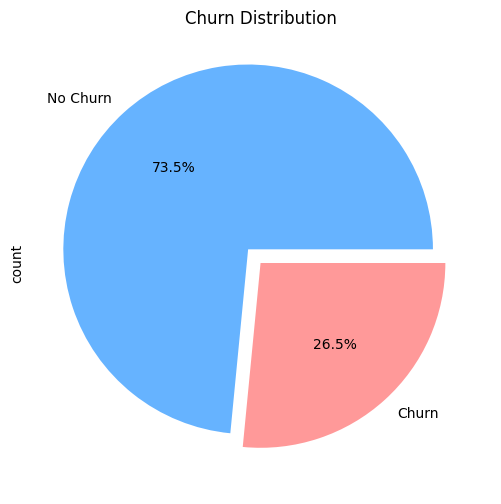

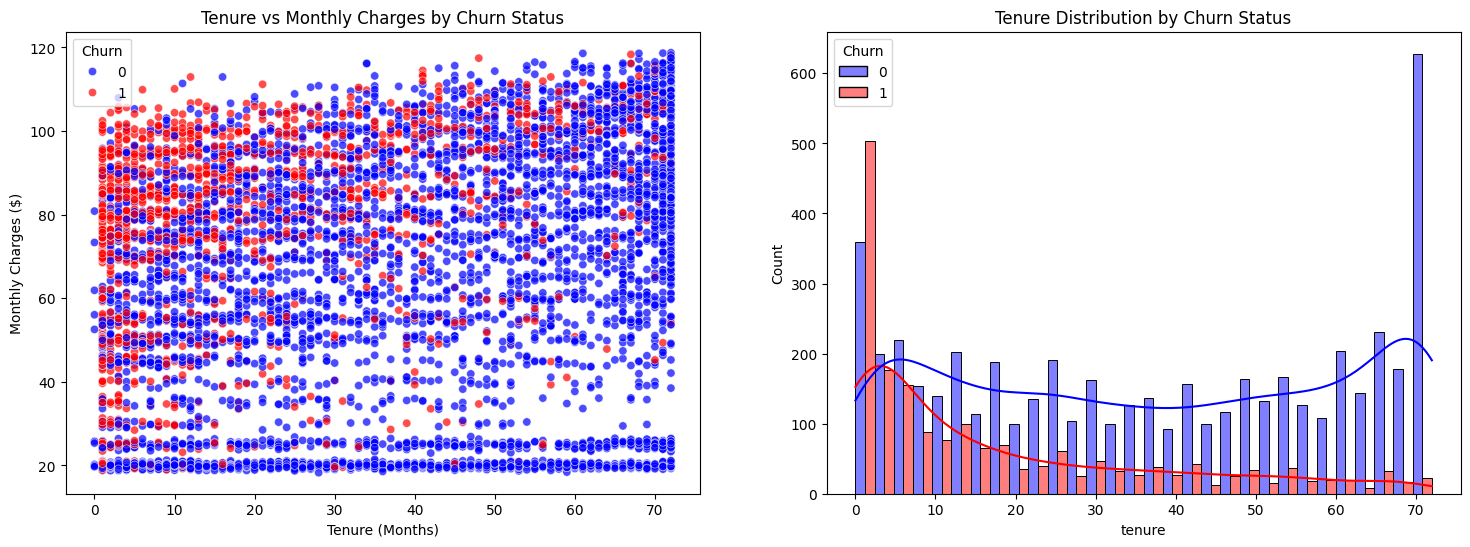

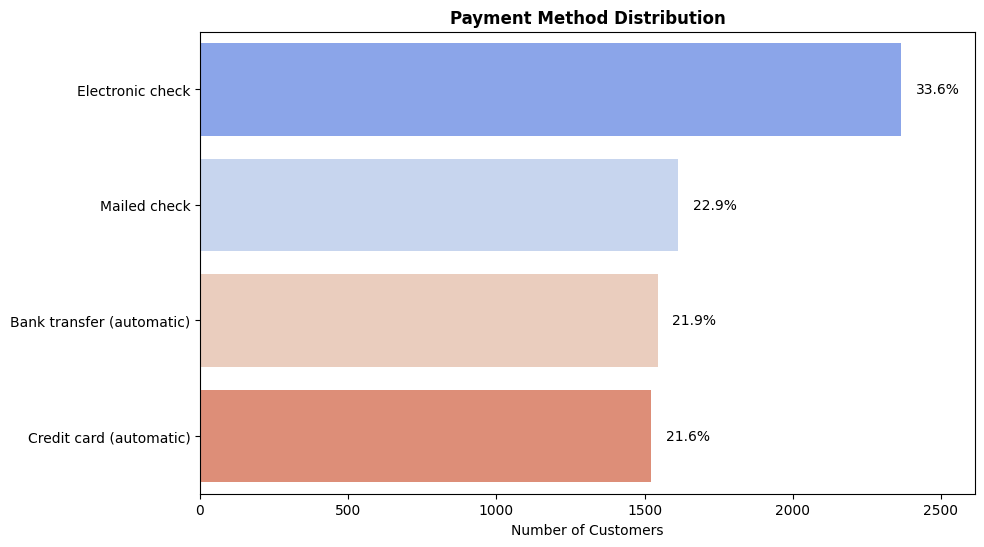

<Figure size 800x500 with 0 Axes>

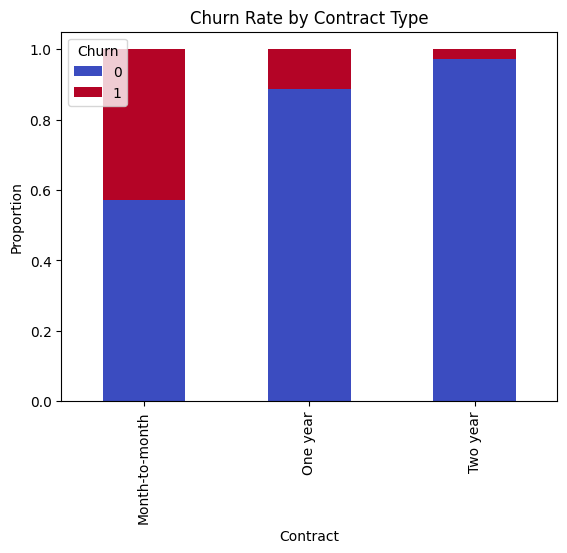

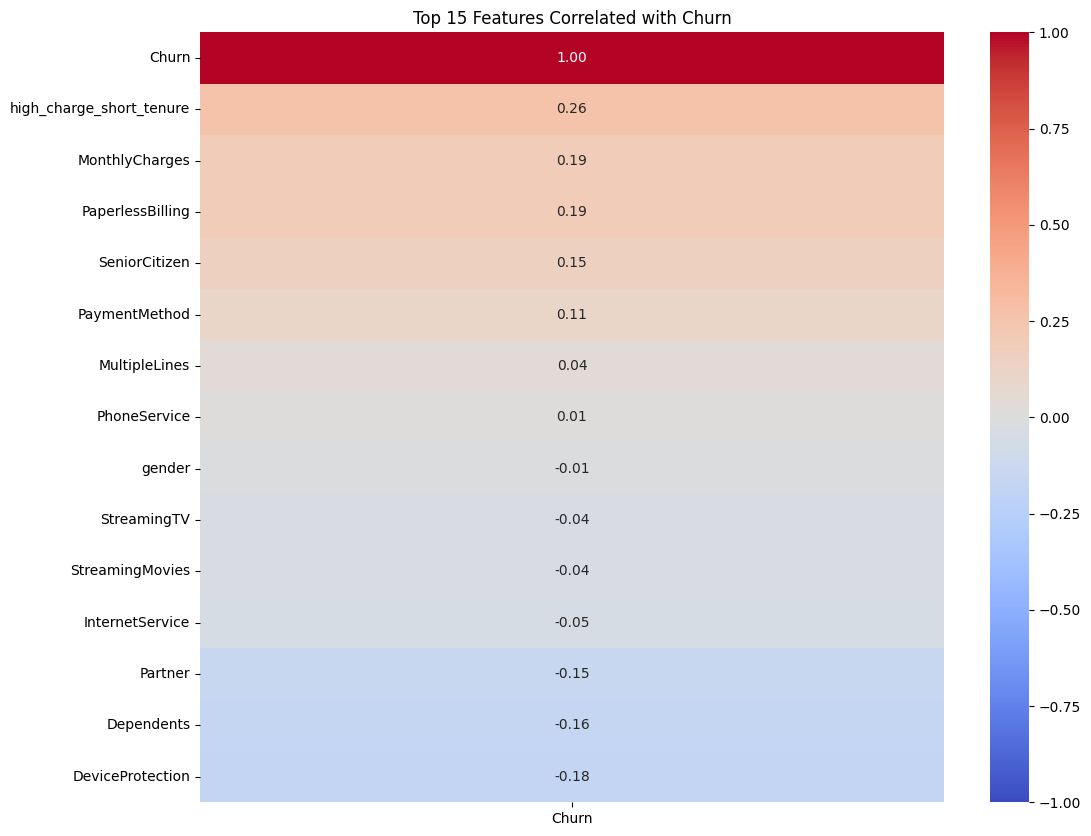


Logistic Regression
Accuracy: 0.7516
F2-Score: 0.7153
AUC-ROC: 0.8484
              precision    recall  f1-score   support

           0       0.91      0.74      0.81      1035
           1       0.52      0.79      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



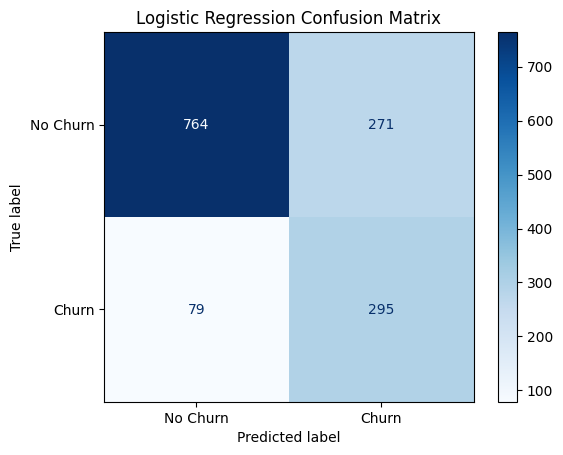

Saved Logistic Regression model | F2: 0.7153


KNN
Accuracy: 0.7722
F2-Score: 0.5233
AUC-ROC: 0.8128
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.58      0.51      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.76      0.77      0.77      1409



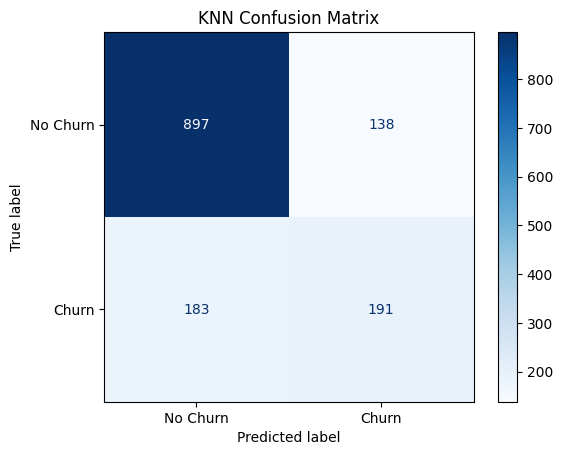

Saved KNN model | F2: 0.5233


SVM
Accuracy: 0.7885
F2-Score: 0.4807
AUC-ROC: 0.7826
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1035
           1       0.65      0.45      0.53       374

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.77      0.79      0.78      1409



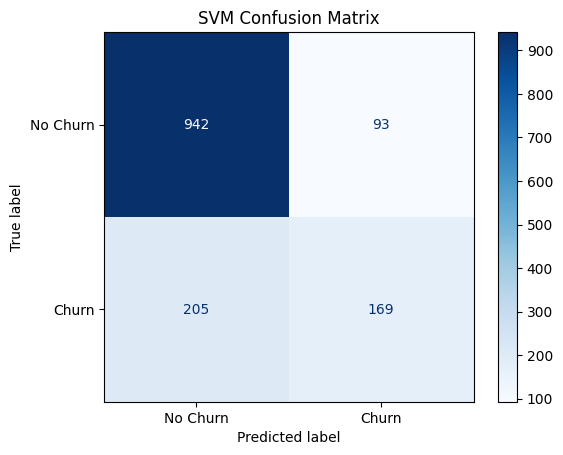

Saved SVM model | F2: 0.4807


Decision Tree
Accuracy: 0.7296
F2-Score: 0.4939
AUC-ROC: 0.6544
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1035
           1       0.49      0.49      0.49       374

    accuracy                           0.73      1409
   macro avg       0.65      0.65      0.65      1409
weighted avg       0.73      0.73      0.73      1409



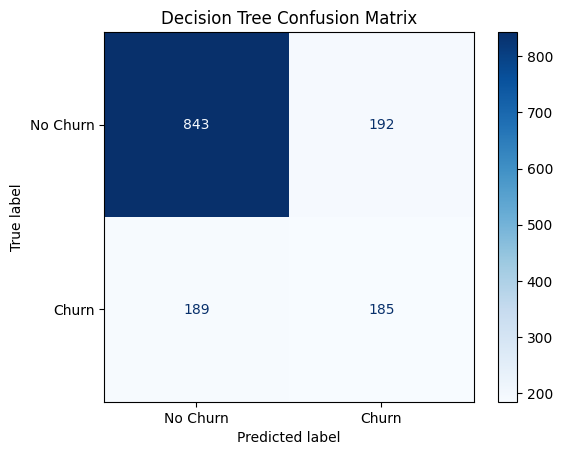

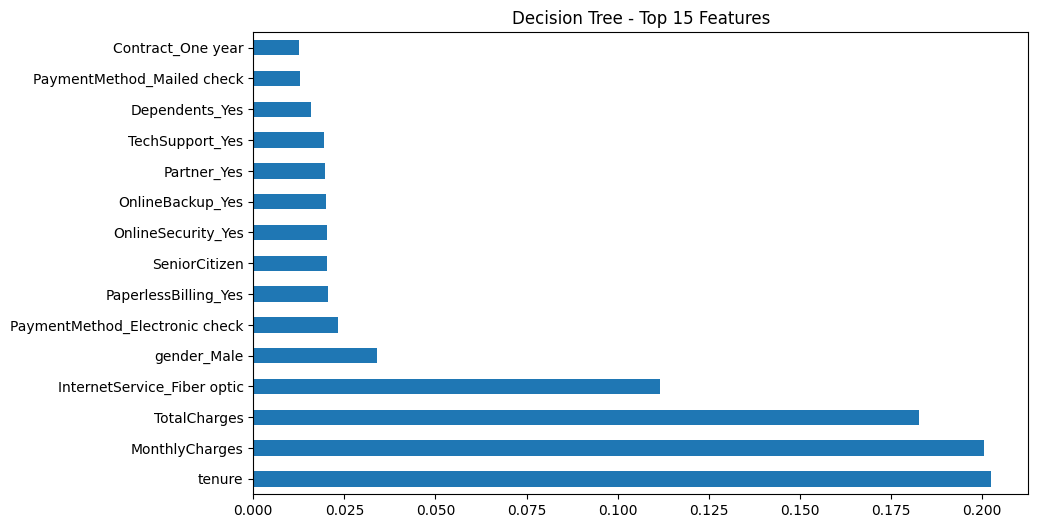

Saved Decision Tree model | F2: 0.4939


Random Forest
Accuracy: 0.7786
F2-Score: 0.4723
AUC-ROC: 0.8213
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1035
           1       0.61      0.45      0.52       374

    accuracy                           0.78      1409
   macro avg       0.72      0.67      0.69      1409
weighted avg       0.76      0.78      0.77      1409



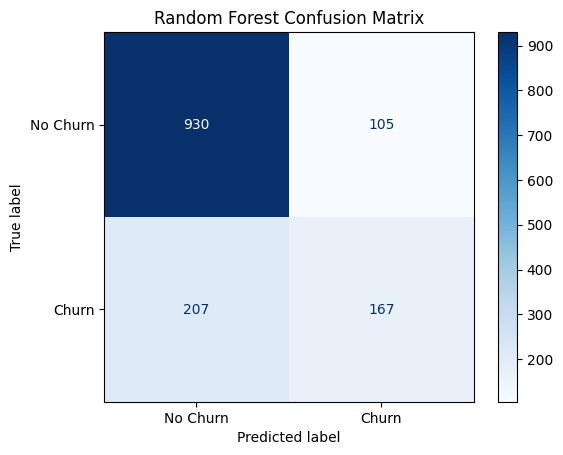

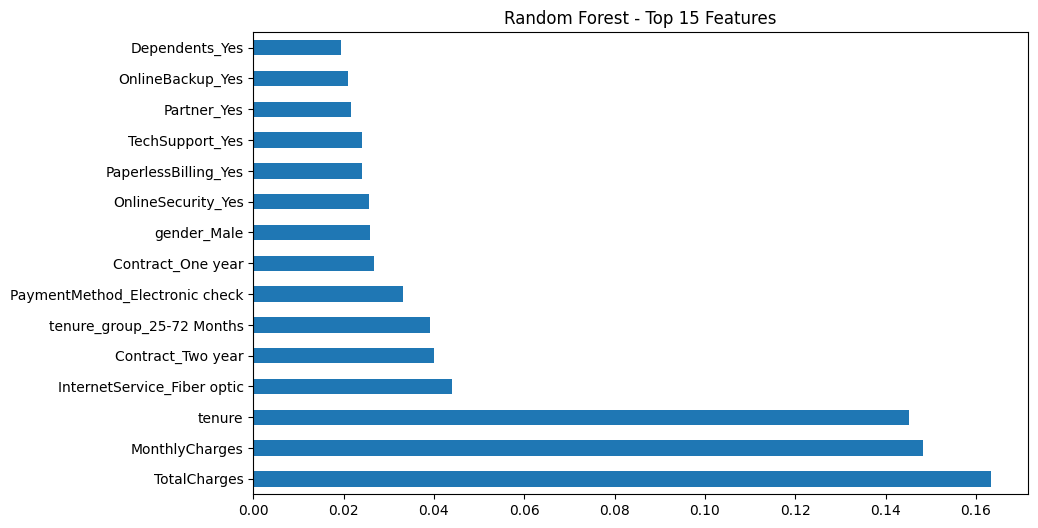

Saved Random Forest model | F2: 0.4723


AdaBoost
Accuracy: 0.7970
F2-Score: 0.5247
AUC-ROC: 0.8519
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



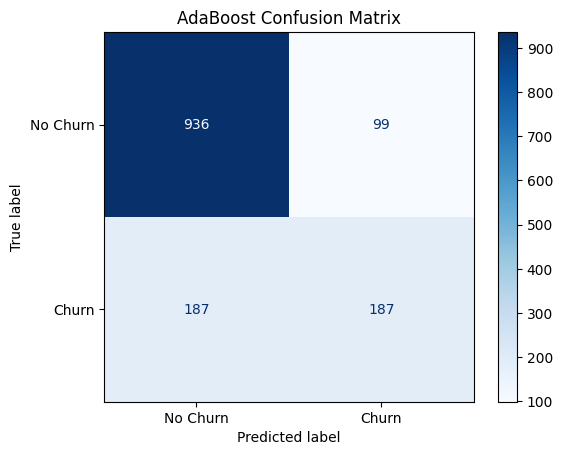

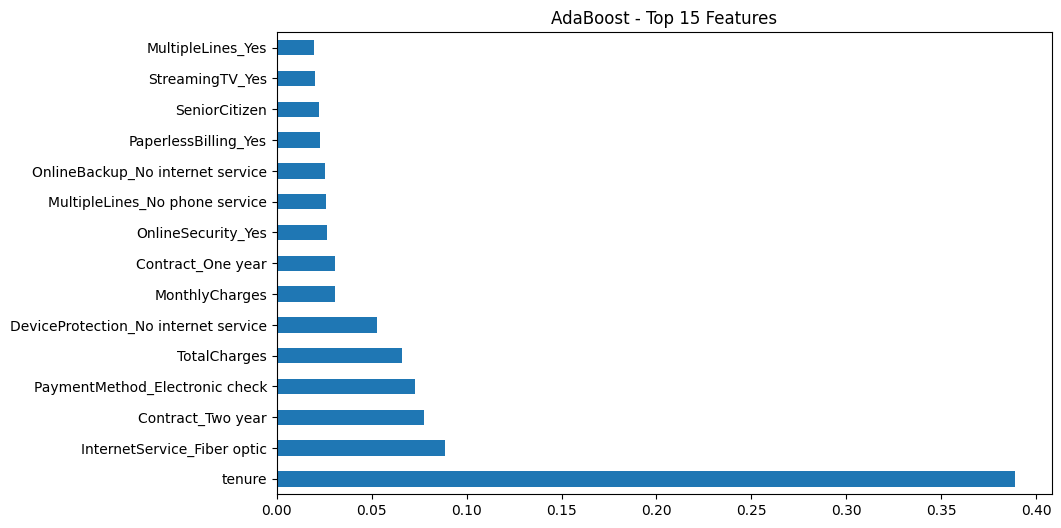

Saved AdaBoost model | F2: 0.5247


Gradient Boosting
Accuracy: 0.7963
F2-Score: 0.5354
AUC-ROC: 0.8492
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



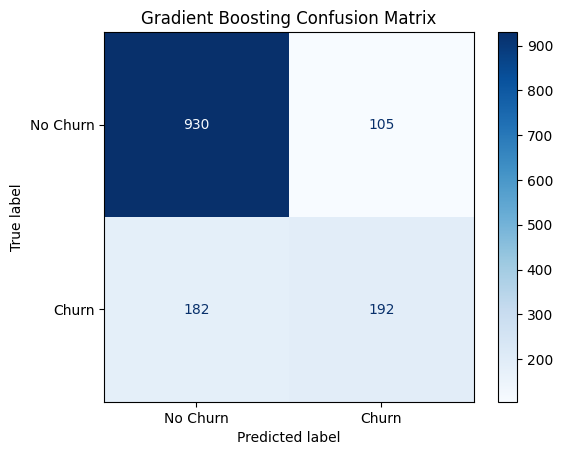

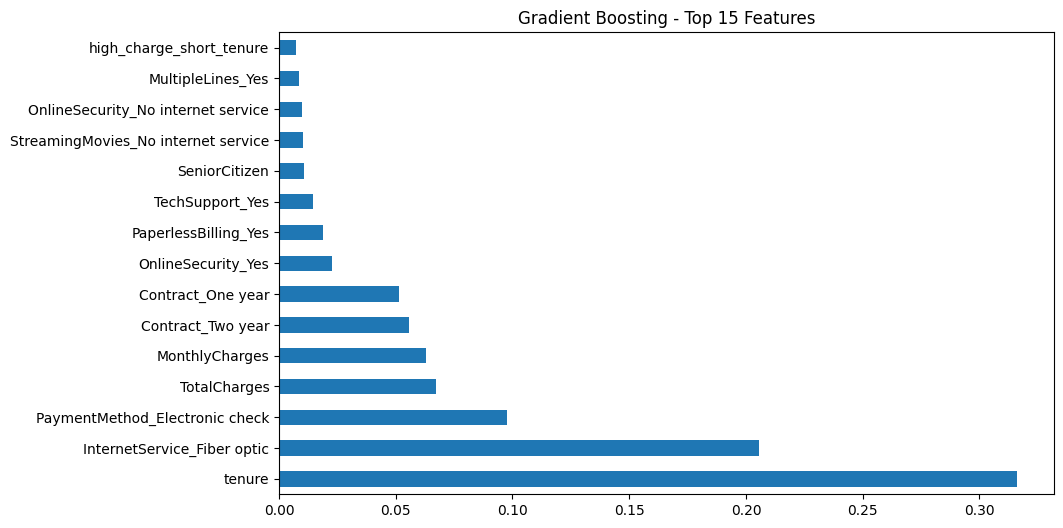

Saved Gradient Boosting model | F2: 0.5354


XGBoost
Accuracy: 0.7601
F2-Score: 0.7299
AUC-ROC: 0.8510
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1035
           1       0.53      0.80      0.64       374

    accuracy                           0.76      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.76      0.77      1409



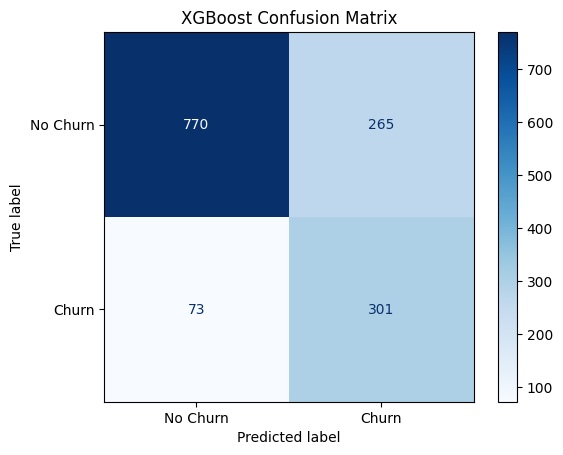

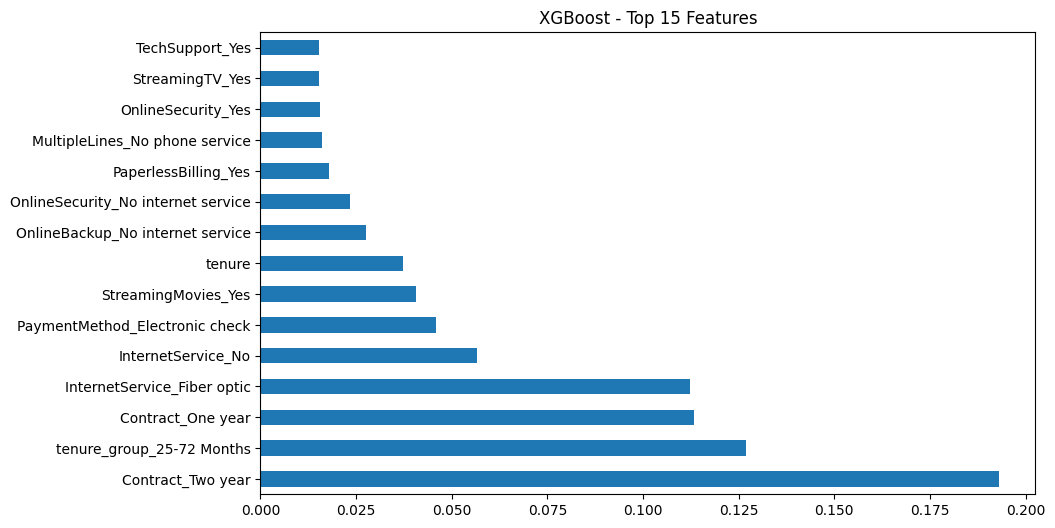

Saved XGBoost model | F2: 0.7299


Final Model Comparison:


,Model,Accuracy,AUC-ROC,F1-Score
5,AdaBoost,0.7970,0.8519,0.5667
7,XGBoost,0.7601,0.8510,0.6404
6,Gradient Boosting,0.7963,0.8492,0.5723
0,Logistic Regression,0.7516,0.8484,0.6277
4,Random Forest,0.7786,0.8213,0.5170
1,KNN,0.7722,0.8128,0.5434
2,SVM,0.7885,0.7826,0.5314
3,Decision Tree,0.7296,0.6544,0.4927



Example Prediction:
Predicted: 0 | Actual: 0


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# Create directories
Path("../data/processed").mkdir(parents=True, exist_ok=True)
Path("../results/plots").mkdir(parents=True, exist_ok=True)
Path("../results/models").mkdir(parents=True, exist_ok=True)

# Modeling imports
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import NotFittedError
from sklearn.metrics import f1_score, fbeta_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, 
                            ConfusionMatrixDisplay, 
                            roc_auc_score,
                            accuracy_score)

# Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import (RandomForestClassifier, 
                             AdaBoostClassifier,
                             GradientBoostingClassifier)
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# --------------------------
# Data Loading & Cleaning
# --------------------------
df = pd.read_csv('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Data cleaning
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df = df.drop('customerID', axis=1)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# --------------------------
# Feature Engineering
# --------------------------
df['tenure_group'] = pd.cut(
    df['tenure'],
    bins=[0, 6, 12, 24, 72],
    labels=['0-6 Months', '7-12 Months', '13-24 Months', '25-72 Months']
)
df['high_charge_short_tenure'] = (
    (df['MonthlyCharges'] > 75) & (df['tenure'] < 6)
).astype(int)

# --------------------------
# Feature Validation
# --------------------------
print("\n=== Feature Validation ===")
print("Tenure Group Distribution (Key Segments):")
print(df['tenure_group'].value_counts(normalize=True).loc[['0-6 Months', '25-72 Months']])

print("\nHigh Charge + Short Tenure:")
print(f"{df['high_charge_short_tenure'].mean() * 100:.1f}% of customers")
print("Churn Rates:")
print(df.groupby('high_charge_short_tenure')['Churn'].mean().apply(lambda x: f"{x:.1%}"))

# Save processed data
df.to_csv('../data/processed/cleaned_churn_data.csv', index=False)

# --------------------------
# Visualizations
# --------------------------
# Churn distribution
plt.figure(figsize=(6,6))
df['Churn'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    labels=['No Churn', 'Churn'],
    colors=['#66b3ff','#ff9999'],
    explode=[0.1, 0]
)
plt.title('Churn Distribution')
plt.savefig('../results/plots/churn_distribution.png', bbox_inches='tight')
plt.show()

# Tenure vs Charges Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Scatter plot
sns.scatterplot(
    data=df, x='tenure', y='MonthlyCharges', hue='Churn',
    palette={0: 'blue', 1: 'red'}, alpha=0.7, ax=ax1
)
ax1.set_title('Tenure vs Monthly Charges by Churn Status')
ax1.set_xlabel('Tenure (Months)')
ax1.set_ylabel('Monthly Charges ($)')

# Histogram
sns.histplot(
    data=df, x='tenure', hue='Churn', multiple='dodge',
    bins=30, palette={0: 'blue', 1: 'red'}, kde=True,
    common_norm=False, ax=ax2
)
ax2.set_title('Tenure Distribution by Churn Status')

plt.savefig('../results/plots/tenure_analysis.png', bbox_inches='tight')
plt.show()

# Payment method distribution - Horizontal Bar Plot
plt.figure(figsize=(10, 6))
payment_counts = df['PaymentMethod'].value_counts()

# Create ordered bar plot with percentages and proper hue handling
ax = sns.barplot(
    x=payment_counts.values,
    y=payment_counts.index,
    hue=payment_counts.index,  # Assign y variable to hue
    palette='coolwarm',
    order=payment_counts.index,
    legend=False  # Disable redundant legend
)

# Add percentage labels
for i, count in enumerate(payment_counts):
    percentage = (count / len(df)) * 100
    ax.text(
        x=count + 50,
        y=i,
        s=f'{percentage:.1f}%', 
        va='center',
        fontsize=10
    )

plt.title('Payment Method Distribution', fontweight='bold')
plt.xlabel('Number of Customers')
plt.ylabel('')
plt.xlim(0, payment_counts.max() + 250)
plt.savefig('../results/plots/payment_methods.png', bbox_inches='tight')
plt.show()


# Contract analysis
plt.figure(figsize=(8,5))
pd.crosstab(df['Contract'], df['Churn'], normalize='index').plot(
    kind='bar', stacked=True, cmap='coolwarm'
)
plt.title('Churn Rate by Contract Type')
plt.ylabel('Proportion')
plt.savefig('../results/plots/contract_churn.png', bbox_inches='tight')
plt.show()

# Correlation analysis

# Create encoded copy for correlation analysis
encoded_df = df.copy()
# Encode ALL categorical features (both object and category dtypes)
for col in encoded_df.select_dtypes(include=['object', 'category']).columns:
    encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col])

# Compute correlations
corr_matrix = encoded_df.corr()

plt.figure(figsize=(12,10))
sns.heatmap(
    corr_matrix[['Churn']]
    .sort_values(by='Churn', ascending=False)
    .head(15),
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1,
    fmt=".2f"
)
plt.title('Top 15 Features Correlated with Churn')
plt.savefig('../results/plots/heatmap_top_correlations.png', bbox_inches='tight')
plt.show()


# %% [markdown]
# Data Preprocessing Pipeline

# %%
# Identify feature types
X = df.drop('Churn', axis=1)
y = df['Churn']

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first'), cat_cols)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=9
)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names
cat_encoder = preprocessor.named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(cat_cols)
all_features = num_cols + list(cat_features)

# ## 5. Model Training & Evaluation
def train_evaluate_model(model, model_name):
    """Train and evaluate a model with standardized output"""
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:,1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2, average='binary')
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    
    # Print comprehensive report
    print(f"\n{'='*40}\n{model_name}\n{'='*40}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F2-Score: {f2:.4f}")
    if not np.isnan(roc_auc):
        print(f"AUC-ROC: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    disp = ConfusionMatrixDisplay.from_estimator(
        model, X_test_processed, y_test,
        cmap=plt.cm.Blues, display_labels=['No Churn', 'Churn']
    )
    disp.ax_.set_title(f'{model_name} Confusion Matrix')
    plt.savefig(f'../results/plots/{model_name}_cm.png', bbox_inches='tight')
    plt.show()

    # Feature importance
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10,6))
        importances = pd.Series(model.feature_importances_, index=all_features)
        importances.nlargest(15).plot(kind='barh')
        plt.title(f'{model_name} - Top 15 Features')
        plt.savefig(f'../results/plots/{model_name}_importance.png', bbox_inches='tight')
        plt.show()
    
    return model, f2

# Calculate scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=25, weights='distance'),
    "SVM": SVC(probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(
        n_estimators=400,
        class_weight='balanced_subsample',
        random_state=9
    ),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(
        eval_metric='logloss',
        scale_pos_weight=scale_pos_weight,  # Use dynamic calculation
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.7
)
}

# Train and evaluate all models
trained_models = {}
metrics = []  # <-- ADD METRICS COLLECTION

for name, model in models.items():
    # Changed to capture both model and f2_score
    trained_model, f2 = train_evaluate_model(model, name)  # <-- UNPACK TUPLE
    trained_models[name] = trained_model
    
    # Save model
    pd.to_pickle(trained_model, f'../results/models/{name.replace(" ", "_")}.pkl')
    
    # Store metrics (ADD THIS BLOCK)
    metrics.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, trained_model.predict(X_test_processed)),
        'F2-Score': f2,
        'AUC-ROC': roc_auc_score(y_test, trained_model.predict_proba(X_test_processed)[:,1]) 
                   if hasattr(trained_model, "predict_proba") else np.nan
    })
    print(f"Saved {name} model | F2: {f2:.4f}\n")

# Generate metrics summary
metrics = []
for name, model in trained_models.items():
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:,1] if hasattr(model, "predict_proba") else None
    
    metrics.append({
        'Model': name,
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'AUC-ROC': round(roc_auc_score(y_test, y_proba), 4) if y_proba is not None else np.nan,
        'F1-Score': round(f1_score(y_test, y_pred), 4)
    })

# Create and display metrics
metrics_df = pd.DataFrame(metrics).sort_values('AUC-ROC', ascending=False)
print("\nFinal Model Comparison:")
display(metrics_df)

# Save metrics to proper directory
metrics_df.to_csv('../results/model_metrics.csv', index=False)  # Changed path

# Load model and validate prediction
xgb_model = pd.read_pickle('../results/models/XGBoost.pkl')

# Convert to DataFrame if using numpy arrays
sample = pd.DataFrame(X_test_processed[0:1], columns=all_features)  # Add feature names
print("\nExample Prediction:")
try:
    print(f"Predicted: {xgb_model.predict(sample)[0]} | Actual: {y_test.values[0]}")
except NotFittedError:
    print("Model not properly trained!")  # .values for numpy array